# Livrable 1 - classification d'images

## Dépendances

In [2]:
#Import des dépendances
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Analyse des données

## Informations sur les données

Classes :  ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Nombre d'images par classe :  [9999, 9993, 10000, 9210, 10000]


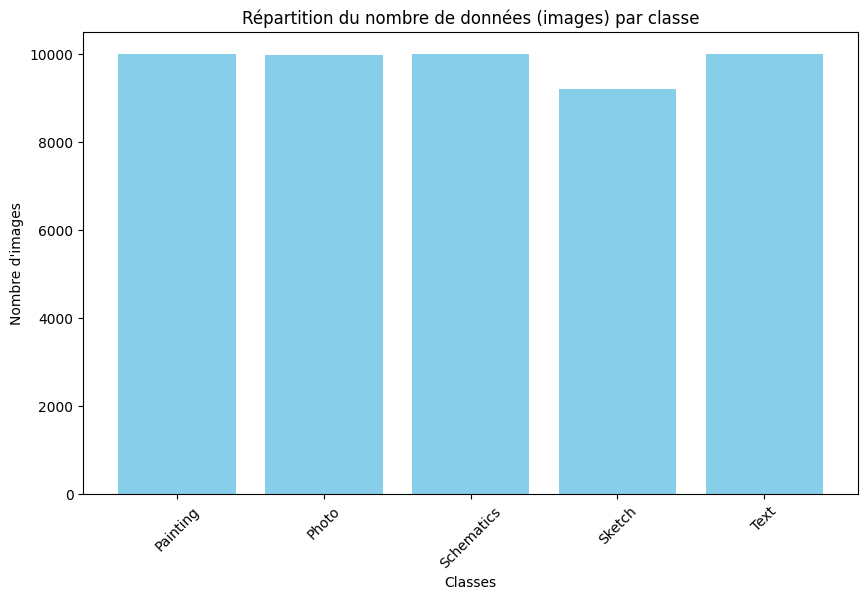

In [12]:
# Chemin vers le dataset
dataset_path = "./Dataset/Dataset1" # Chemin vers le dataset à modifier

# Vérification de l'existence du dossier
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Le dossier {dataset_path} n'existe pas.")

# Récupération des classes et du nombre d'images par classe
classes = []
image_counts = []

# Parcours des fichiers dans le dataset
for class_name in os.listdir(dataset_path):  # Parcours des fichiers dans le dataset
    class_path = os.path.join(dataset_path, class_name)  # Chemin vers le fichier
    classes.append(class_name.replace('Dataset Livrable 1 - ',''))  # Ajout du nom de la classe sans l'extension
    image_counts.append(len(os.listdir(class_path)))  # Comptage des fichiers dans le dossier

# Affichage des classes et du nombre d'images par classe
print("Classes : ", classes)
print("Nombre d'images par classe : ", image_counts)

# Affichage de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Répartition du nombre de données (images) par classe')
plt.xticks(rotation=45)
plt.show()

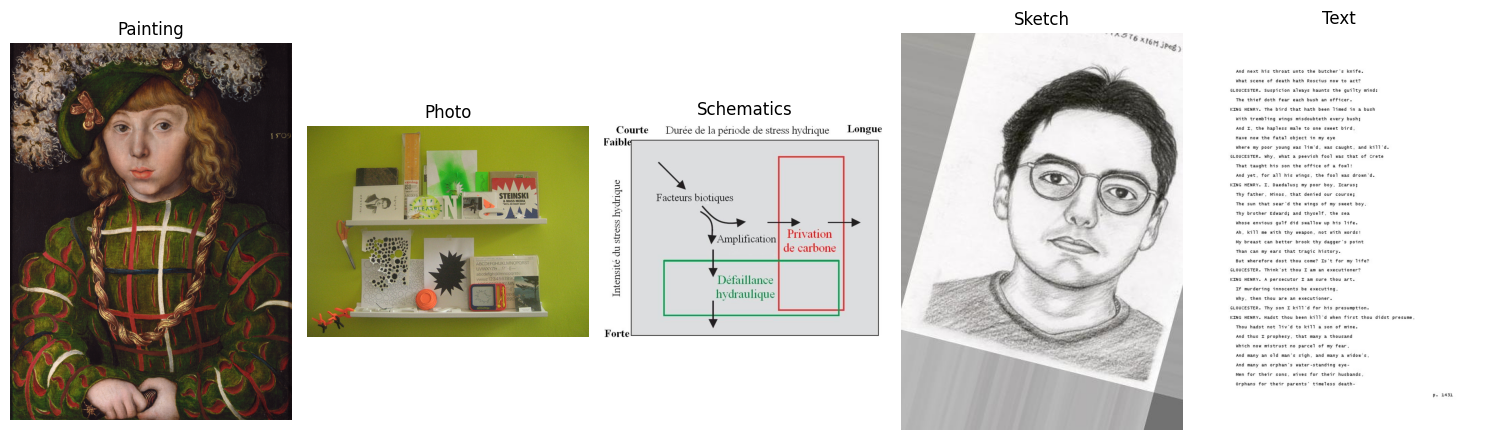

In [24]:
import random
def display_random_images(dataset_path):
    """
    Affiche un nombre aléatoire d'images d'une classe donnée.
    
    :param dataset_path: Chemin vers le dataset
    :param num_images: Nombre d'images à afficher (par défaut 5)
    """
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        img = PIL.Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

display_random_images(dataset_path)  # Affichage de 5 images aléatoires d'une classe donnée

## Nettoyage des données

In [ ]:
# Suppresion des fichiers corrompus ou non images --------------------------------------------------------------------
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path): 
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")


In [ ]:
import os
import shutil

def separate_images(source_folder):
    # Définition des dossiers de destination
    jpg_folder = source_folder + "_jpg"
    png_folder = source_folder + "_png"
    
    # Création des dossiers s'ils n'existent pas
    os.makedirs(jpg_folder, exist_ok=True)
    os.makedirs(png_folder, exist_ok=True)
    
    # Parcours des fichiers dans le dossier source
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        
        # Vérification que c'est bien un fichier
        if os.path.isfile(file_path):
            if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
                shutil.move(file_path, os.path.join(jpg_folder, filename))
            elif filename.lower().endswith(".png"):
                shutil.move(file_path, os.path.join(png_folder, filename))
    
    print("Séparation terminée !")

# Exemple d'utilisation
source_directory = "./Dataset/Dataset1/Sketch/"
separate_images(source_directory)

Séparation terminée !


## Import des données

In [5]:
image_size = (180, 180)  # Taille des images
batch_size = 32  # Taille du lot


# chargement des images
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

Found 42804 files belonging to 6 classes.
Using 34244 files for training.
Found 42804 files belonging to 6 classes.
Using 8560 files for validation.


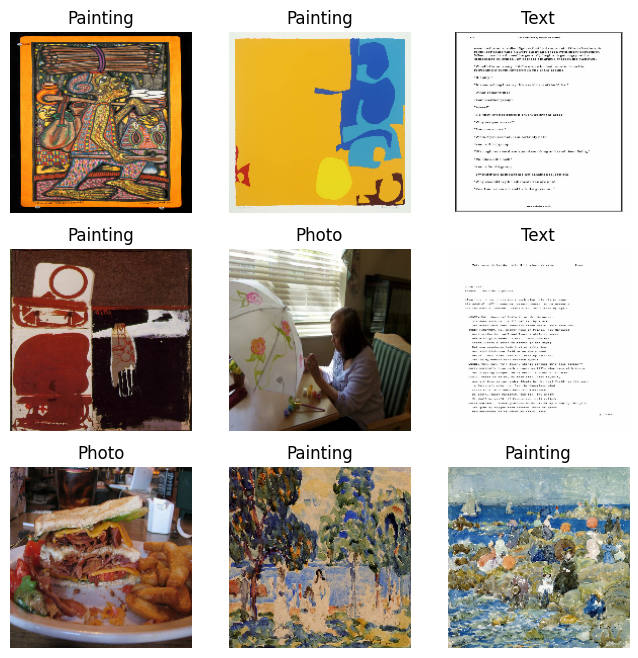

In [6]:
class_names = train_set.class_names
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
        plt.imshow(images[i].numpy().astype("uint8"))
    plt.show()

## Data dugmentation

In [ ]:
# Générateur de données avec augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontal et vertical
    layers.RandomRotation(0.2),  # Rotation aléatoire
    layers.RandomZoom(0.2),  # Zoom aléatoire
])

# Exemple d'application de la data augmentation sur un lot d'images
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):  # Prendre un lot d'images du train_set
    for i in range(9):  # Afficher 9 images augmentées
        augmented_image = data_augmentation(images[i:i+1])  # Appliquer la data augmentation
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Dossier contenant les images de la classe sous-représentée
minority_class_path = "Dataset/Dataset1/Sketch"

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générer de nouvelles images
images = os.listdir(minority_class_path)
for image_name in images:
    img_path = os.path.join(minority_class_path, image_name)
    img = load_img(img_path)  # Charger l'image
    img = img_to_array(img)   # Convertir en tableau numpy
    img = np.expand_dims(img, axis=0)

    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=minority_class_path, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 2:  # Générer environ 2 nouvelles images par image existante (pour arriver à 10k)
            break


KeyboardInterrupt: 

## Ponderation

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Définition des classes et des étiquettes
y_train = np.array(classes)  # Remplace par tes labels

# Calcul des poids
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Poids des classes :", class_weights_dict)
# Entraînement du modèle avec pondération
#model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weights_dict)


# Pipeline Classification

# Pipeline Denoising

# Pipeline Captioning